<a href="https://colab.research.google.com/github/minaraaz/MachineLearningCourse/blob/master/HW3/HW3_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4
In this colab I applyed t-SNE visualization to activation model obtain the corresponding activations for the validation images.

In [0]:
import os
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive

# Loading the model from Drive
[Here](https://drive.google.com/file/d/1p0hGJNOqY0dJEAIUNdwMPrE5KxxWvV3t/view?usp=sharing) is the model saved in the Drive.

In [0]:
from keras.models import load_model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)
file_obj = drive.CreateFile({'id': '1p0hGJNOqY0dJEAIUNdwMPrE5KxxWvV3t'})                       
file_obj.GetContentFile('VGG19-Finetuned-Cats_and_Dogs.h5')

In [0]:
model = load_model('VGG19-Finetuned-Cats_and_Dogs.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Loading test image

In [36]:
!wget https://github.com/minaraaz/MachineLearningCourse/blob/master/HW3/dog.jpg?raw=true \
  -O dog.jpg

--2019-04-16 23:03:36--  https://github.com/minaraaz/MachineLearningCourse/blob/master/HW3/dog.jpg?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/minaraaz/MachineLearningCourse/raw/master/HW3/dog.jpg [following]
--2019-04-16 23:03:37--  https://github.com/minaraaz/MachineLearningCourse/raw/master/HW3/dog.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/minaraaz/MachineLearningCourse/master/HW3/dog.jpg [following]
--2019-04-16 23:03:37--  https://raw.githubusercontent.com/minaraaz/MachineLearningCourse/master/HW3/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.

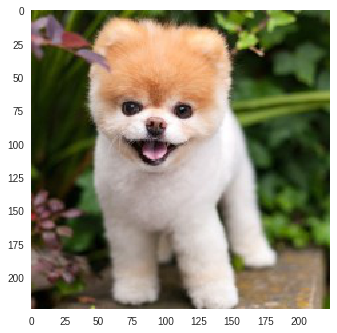

In [37]:
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.grid(None)
plt.show()

In [38]:
model.predict(img_tensor)

array([[4.9471285e-04, 9.9950528e-01]], dtype=float32)

In [0]:
layer = model.get_layer('fc1')
layer_output = layer.output
activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


# Preprocessing test dataset

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-16 21:15:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  18.1MB/s    in 3.6s    

2019-04-16 21:16:02 (18.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
test_dir = os.path.join(base_dir, 'validation')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 1000 images belonging to 2 classes.


# Creating activation model

In [0]:
activations = activation_model.predict_generator(test_generator,verbose=1,steps = 1000)

1000/1000 [==============================] - 13s 13ms/step


In [0]:
activations.shape

(1000, 256)

In [0]:
class_names = (test_generator.class_indices)

In [0]:
y_true = test_generator.classes

# Visualizing t-SNE

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("pastel", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [34]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

catdog_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 8.09647989273 seconds


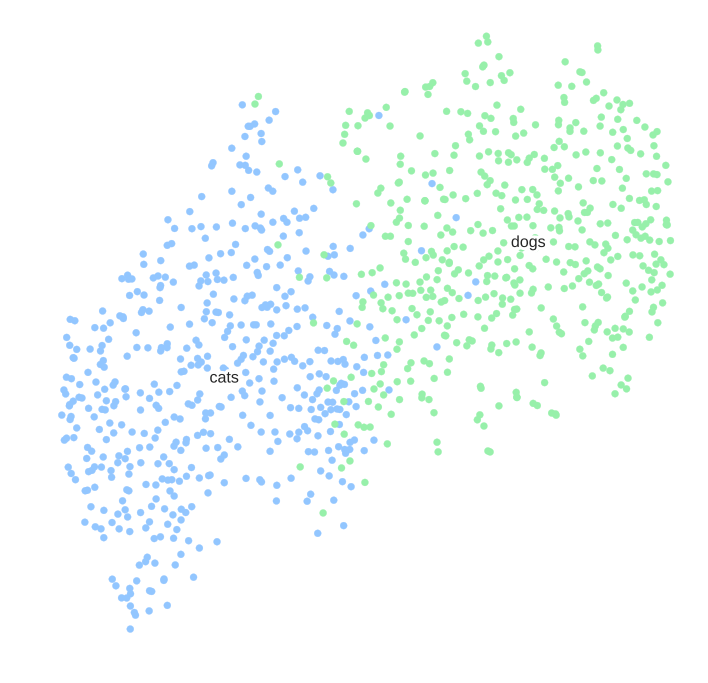

In [35]:
class_names = ['cats','dogs']
data_scatter(catdog_tsne, y_true)